In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import numpy as np 
from recoMRD import recoMRD
from recoMRD import utils
from bart import bart

In [2]:
filename = './../example_data/meas_MID00019_FID04966_localizer2D_iPAT2.mrd'
mrd = recoMRD(filename)

kspace_osremoved = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
img_sos = mrd.coil_combination(kspace_osremoved, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 72
Number of image     scans: 336
k-space size in protocol: 448 x 224 x 1
image   size in protocol: 224 x 224 x 1
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled array size=[16, 448, 224, 1, 3, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[16, 448, 24, 1, 3, 1, 1, 1, 1, 1, 1]: 100%|███████████████████████████████████████████████████████| 72/72 [00:00<00:00, 15450.21it/s]
Filling noise     , size=[16, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3063.77it/s]
Filling image_scan, size=[16, 448, 112, 1, 3, 1, 1, 1, 1, 1, 1]: 100%|█████████████████████████████████████████████████████| 336/336 [00:00<00:00, 5909.95it/s]


Reorder slice... Done.
Remove oversampling... Done.


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 296.99it/s]


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(224, 224, 3)


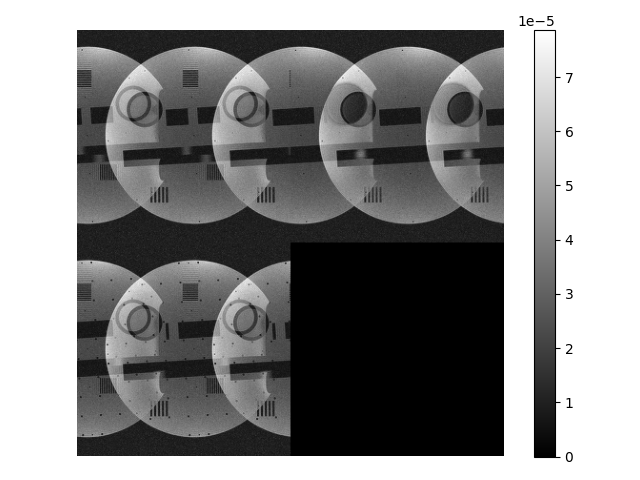

In [3]:
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()
temp = utils.plot_mosaic(temp, cmap='gray')

(448, 224, 3)
Acceleration Factor: R=2.00


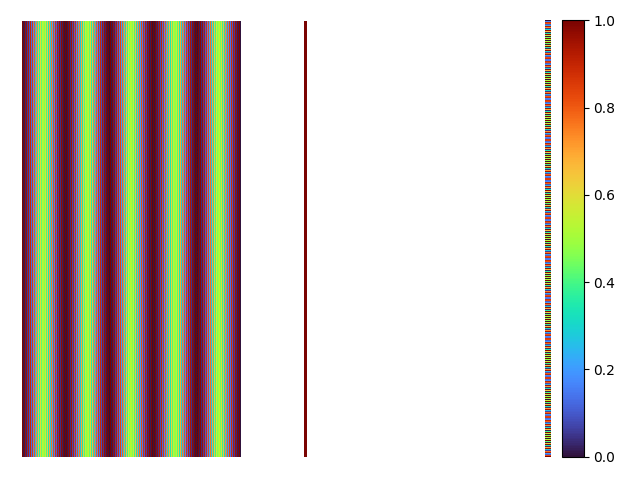

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...] # take the first coil
mask = bart.bart(1, 'pattern', temp).real > 0
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
utils.plot3D(mask, clim=[0, 1])
print('Acceleration Factor: R={:.2f}'.format(R))

(16, 448, 224, 3)
(448, 3584)


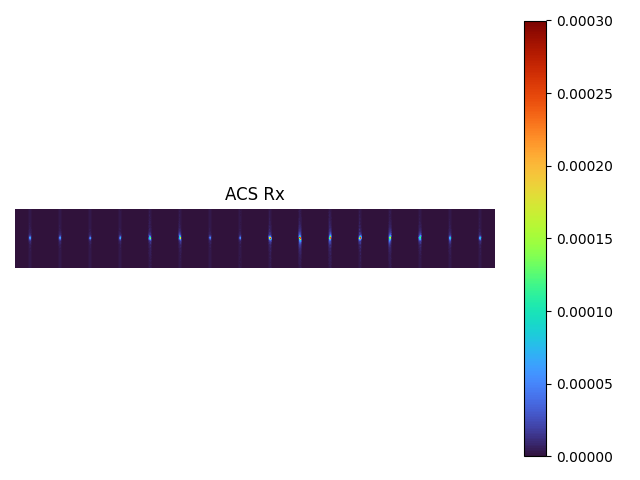

In [5]:
# show some Rx channels from reference scan
temp = mrd.kspace['acs'].squeeze()
print(temp.shape)
temp = np.abs(np.moveaxis(temp[:,:,:,1],0,-1))
temp = utils.plot_mosaic(temp, grid_shape = [1, temp.shape[2]], clim=[0, 3e-4], title='ACS Rx')
print(temp.shape)

Remove oversampling... Done.


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 284.86it/s]

(1, 224, 224, 1, 3, 1, 1, 1, 1, 1, 1)
(224, 224, 3)


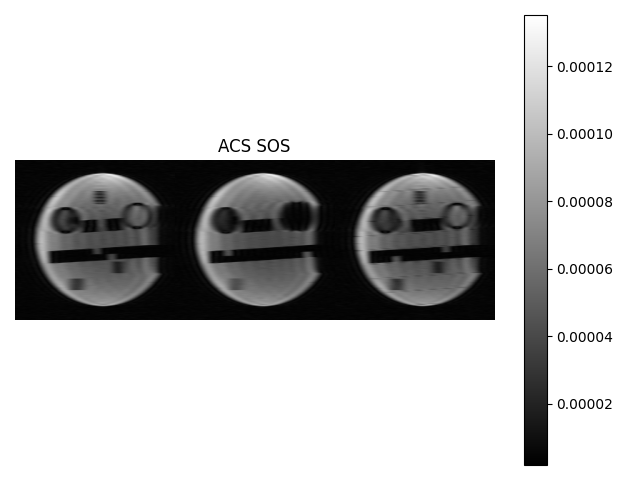

In [6]:
# sum of square of reference scan
acs = mrd.remove_oversampling(mrd.kspace['acs'], is_kspace=True)
acs_img = mrd.coil_combination(acs, method='sos')

temp = acs_img.squeeze()
print(acs_img.shape)
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [1, temp.shape[2]], cmap='gray', title='ACS SOS')


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity_espirit = mrd.calc_coil_sensitivity(acs, method='espirit')
print(coils_sensitivity_espirit.shape)

Done.
Done.
Done.
(16, 224, 224, 1, 3)
CPU times: user 35.5 ms, sys: 36.3 ms, total: 71.8 ms
Wall time: 2.04 s


In [8]:
%%time
# use caldir method to get coil sensitivity 
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(acs, method='caldir')
print(coils_sensitivity_caldir.shape)

Calibration region 112x24x1
Done.
Calibration region 112x24x1
Done.
Calibration region 112x24x1
Done.
(16, 224, 224, 1, 3)
CPU times: user 34.8 ms, sys: 19 ms, total: 53.7 ms
Wall time: 801 ms


In [9]:
%%time
# using walsh method to get coil sensitivity
coils_sensitivity_walsh = mrd.calc_coil_sensitivity(acs, method='walsh')
print(coils_sensitivity_walsh.shape)

Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 288.09it/s]


(16, 224, 224, 1, 3)
CPU times: user 6.31 s, sys: 41.2 ms, total: 6.35 s
Wall time: 449 ms


(48, 224, 224)
(224, 224, 48)


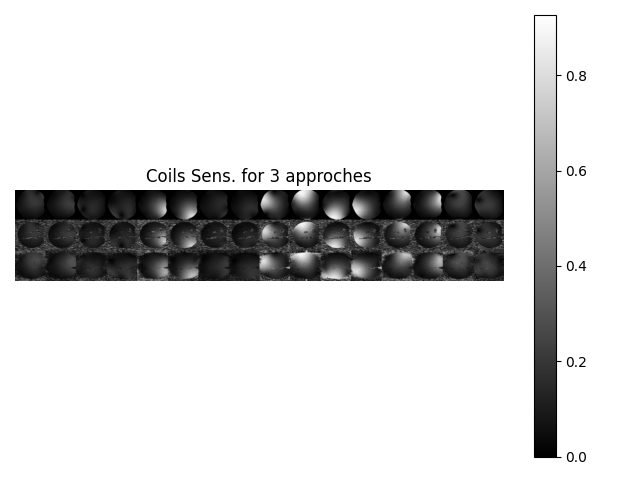

In [10]:
temp = np.concatenate((coils_sensitivity_espirit, coils_sensitivity_caldir, coils_sensitivity_walsh), axis = 0)
temp = temp.squeeze()[...,1]
print(temp.shape)
temp = np.abs(np.moveaxis(temp,0,-1))
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [3, temp.shape[2]/3], cmap='gray', title='Coils Sens. for 3 approches')


Remove oversampling... Done.
(16, 224, 224, 1, 3, 1, 1, 1, 1, 1, 1)


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 235.74it/s]

Size: 50176 Samples: 25088 Acc: 2.00


l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.623392
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.580196
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.803756


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 269.91it/s]


Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.691955
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.581677
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.595149


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 310.74it/s]

Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients


Total Time: 0.666348
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.597373
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.542489
(1, 224, 224, 1, 3, 1, 1, 1, 1, 1, 1)
(224, 224, 9)


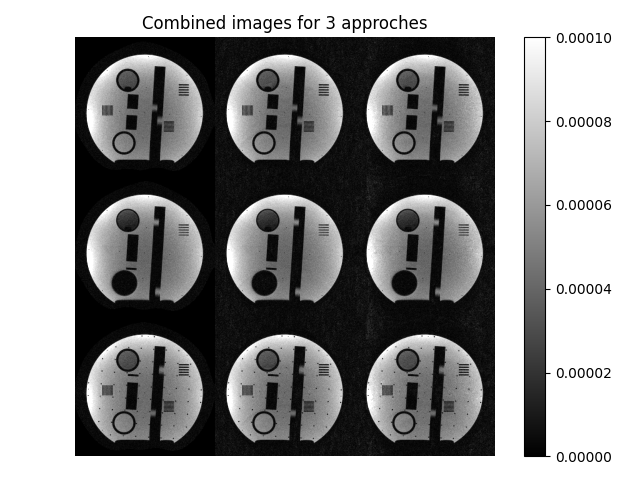

In [11]:
img = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
print(img.shape)
volume_comb_espirit = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_espirit)
volume_comb_caldir  = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir)
volume_comb_walsh   = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_walsh)
print(volume_comb_espirit.shape)
temp = np.concatenate((volume_comb_espirit, volume_comb_caldir, volume_comb_walsh), axis = 4).squeeze()
temp = np.abs(temp)
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [3, temp.shape[2]//3], cmap='gray', clim = [0, 1e-4], transpose = True, title='Combined images for 3 approches')
